# Compare the General Performance of CABG
 - Create a dataframe containing the severity of stenosis using FFR, and if the stenosis subtended territory is ischemic.
 - Add the point-based or voxel-based MBF value to the data-frame (or create a new one?)
 - Violin Plots:
    - Pre/Post MBF against ischemic-grafted, non-ischemic-grafted, non-ischemic nongrafted
    - Pre/Post MBF against severity of stenosis (none, mild, moderate, severe)

In [1]:
import glob
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utilities import ReadVTUFile, ThresholdInBetween
from vtk.util.numpy_support import vtk_to_numpy, numpy_to_vtk

In [ ]:
path = "/Users/ana/Documents/AnahitaSeresti/05_PrePostCABG/InterPatientStudy"
metadata = glob.glob(f"{path}/*.xlsx")
VTUFiles = glob.glob(f"{path}/*.vtu")
TerritoryLabels = glob.glob(f"{path}/*.dat")
print(VTUFiles)

PatientMetadata = pd.read_excel(metadata[0], dtype={'column_name': str})
print(PatientMetadata)

In [ ]:
patient_ids = set(PatientMetadata["patient-id"])
print(patient_ids)

In [4]:
def ReadLabels(InputLabels, TerritoryTag):
    MBF_Labels = {}
    for tag in TerritoryTag:
        MBF_Labels[f"{tag}"] =  []
    MBF_Labels["Nongrafted"] = []
    keys = list(MBF_Labels.keys())[:-1]
    with open(InputLabels, "r") as ifile:
        for i, LINE in enumerate(ifile):
            if i == 0: 
                continue
            line = LINE.split()
            found = False
            for key in keys:
                if line[1].find(key)>=0: 
                    MBF_Labels[key].append(int(line[0]))
                    found = True
                    break
            if not found: 
                MBF_Labels["Nongrafted"].append(int(line[0]))

    MBF_Labels = {k.replace('post_', ''):v for k,v in MBF_Labels.items() if len(v)>0}
    
    return MBF_Labels

def Normalize(MBF):
    for i in range(MBF.GetPointData().GetNumberOfArrays()):
        arrayname_ = MBF.GetPointData().GetArrayName(i)
        if 'scalars' in arrayname_.lower():
            ArrayName = arrayname_
    ScalarArray = MBF.GetPointData().GetArray(ArrayName)
    per_75th = np.percentile(vtk_to_numpy(ScalarArray), 75)
    IndexMBFArray = ScalarArray/per_75th
    IndexMBF = numpy_to_vtk(IndexMBFArray)
    IndexMBF.SetName("IndexMBF")
    MBF.GetPointData().AddArray(IndexMBF)

    return MBF


def CollectMBFData(MBF, Labels):
    for i in range(MBF.GetPointData().GetNumberOfArrays()):
            arrayname_ = MBF.GetPointData().GetArrayName(i)
            if 'scalars' in arrayname_.lower():
                ScalarArray = arrayname_

    AbsMBFData = {}
    IndexMBFData = {}
    for key in Labels.keys():
        AbsMBFData[key] = np.array([])
        IndexMBFData[key] = np.array([])
        for i in Labels[key]:
            territory_ = ThresholdInBetween(MBF, "TerritoryMaps", i, i)
            MBF_ = vtk_to_numpy(territory_.GetPointData().GetArray(ScalarArray))
            iMBF_ = vtk_to_numpy(territory_.GetPointData().GetArray("IndexMBF"))
            AbsMBFData[key] = np.append(AbsMBFData[key], MBF_)
            IndexMBFData[key] = np.append(IndexMBFData[key], iMBF_)
    

    return AbsMBFData, IndexMBFData


In [ ]:
print(PatientMetadata[PatientMetadata['patient-id'] == 'SU03']['stenosis tag'])

In [ ]:
data = []
for patient_id in patient_ids:
    print(patient_id)
    tags = list(PatientMetadata[PatientMetadata['patient-id'] == patient_id]['stenosis tag'])
    ischemia = list(PatientMetadata[PatientMetadata['patient-id'] == patient_id]['is-ischemic'])
    TerritoryTags = [f'post_{tag}' for tag in tags]
    for file in TerritoryLabels:
        if patient_id in os.path.basename(os.path.splitext(file)[0]):
            LabelFile = file
    MBF_Labels = ReadLabels(LabelFile, TerritoryTags)
    for file in VTUFiles:
        if f"{patient_id}A" in os.path.basename(os.path.splitext(file)[0]):
            MBF_A = Normalize(ReadVTUFile(file))
        elif f"{patient_id}B" in os.path.basename(os.path.splitext(file)[0]):
            MBF_B = Normalize(ReadVTUFile(file))
    AbsMBFData_A, IndexMBFData_A = CollectMBFData(MBF_A, MBF_Labels)
    AbsMBFData_B, IndexMBFData_B = CollectMBFData(MBF_B, MBF_Labels)
    for i, t in enumerate(tags):
        data_ = {"patient_id": patient_id, "tag": t, "is_ischemic": ischemia[i], "absMBF_A": AbsMBFData_A[t], "absMBF_B": AbsMBFData_B[t], "IndexMBF_A": IndexMBFData_A[t], "IndexMBF_B": IndexMBFData_B[t]}
        data.append(data_)
    t = "Nongrafted"
    data_ = {"patient_id": patient_id, "tag": t, "is_ischemic": False, "absMBF_A": AbsMBFData_A[t], "absMBF_B": AbsMBFData_B[t], "IndexMBF_A": IndexMBFData_A[t], "IndexMBF_B": IndexMBFData_B[t]}
    data.append(data_)

df = pd.DataFrame(data)
#df


In [ ]:
print("TerritoryTag", "Median", "IQR", "Mean", "std")
index_mbf_ischemic_A = np.concatenate(df[df['is_ischemic'] == True]['IndexMBF_A'].values)
q1, q2, q3 = np.percentile(index_mbf_ischemic_A, [25, 50, 75])
average = np.mean(index_mbf_ischemic_A)
std = np.std(index_mbf_ischemic_A)
print("ischemic_grafted_A", q2, q3-q1, average, std)

index_mbf_ischemic_B = np.concatenate(df[df['is_ischemic'] == True]['IndexMBF_B'].values)
q1, q2, q3 = np.percentile(index_mbf_ischemic_B, [25, 50, 75])
average = np.mean(index_mbf_ischemic_B)
std = np.std(index_mbf_ischemic_B)
print("ischemic_grafted_B",q2, q3-q1, average, std)

index_mbf_nonischemic_A = np.concatenate(df[(df['is_ischemic'] == False) & (df['tag'] != 'Nongrafted')]['IndexMBF_A'].values)
q1, q2, q3 = np.percentile(index_mbf_nonischemic_A, [25, 50, 75])
average = np.mean(index_mbf_nonischemic_A)
std = np.std(index_mbf_nonischemic_A)
print("nonischemic_grafted_A", q2, q3-q1, average, std)

index_mbf_nonischemic_B = np.concatenate(df[(df['is_ischemic'] == False) & (df['tag'] != 'Nongrafted')]['IndexMBF_B'].values)
q1, q2, q3 = np.percentile(index_mbf_nonischemic_B, [25, 50, 75])
average = np.mean(index_mbf_nonischemic_B)
std = np.std(index_mbf_nonischemic_B)
print("nonischemic_grafted_B", q2, q3-q1, average, std)

index_mbf_nongrafted_A = np.concatenate(df[df['tag'] == 'Nongrafted']['IndexMBF_A'].values)
q1, q2, q3 = np.percentile(index_mbf_nongrafted_A, [25, 50, 75])
average = np.mean(index_mbf_nongrafted_A)
std = np.std(index_mbf_nongrafted_A)
print("nongrafted_A", q2, q3-q1)

index_mbf_nongrafted_B = np.concatenate(df[df['tag'] == 'Nongrafted']['IndexMBF_B'].values)
q1, q2, q3 = np.percentile(index_mbf_nongrafted_B, [25, 50, 75])
average = np.mean(index_mbf_nongrafted_B)
std = np.std(index_mbf_nongrafted_B)
print("nongrafted_B", q2, q3-q1, average, std)


"""
def downsample(array, size=1000):
    if len(array) > size:
        return np.random.choice(array, size, replace=False)
    return array

index_mbf_ischemic_A = downsample(index_mbf_ischemic_A)
index_mbf_ischemic_B = downsample(index_mbf_ischemic_B)
index_mbf_nonischemic_A = downsample(index_mbf_nonischemic_A)
index_mbf_nonischemic_B = downsample(index_mbf_nonischemic_B)
index_mbf_nongrafted_A = downsample(index_mbf_nongrafted_A)
index_mbf_nongrafted_B = downsample(index_mbf_nongrafted_B)
"""

In [27]:
# Create a DataFrame with each part
df_A = pd.DataFrame({
    'MBF': np.concatenate([index_mbf_ischemic_A, index_mbf_nonischemic_A, index_mbf_nongrafted_A]),
    'Territory': ['Ischemic Grafted'] * len(index_mbf_ischemic_A) + 
             ['Non-ischemic Grafted'] * len(index_mbf_nonischemic_A) + 
             ['Nongrafted'] * len(index_mbf_nongrafted_A),
    'Type': ['A'] * (len(index_mbf_ischemic_A) + len(index_mbf_nonischemic_A) + len(index_mbf_nongrafted_A))
})

df_B = pd.DataFrame({
    'MBF': np.concatenate([index_mbf_ischemic_B, index_mbf_nonischemic_B, index_mbf_nongrafted_B]),
    'Territory': ['Ischemic Grafted'] * len(index_mbf_ischemic_B) + 
             ['Non-ischemic Grafted'] * len(index_mbf_nonischemic_B) + 
             ['Nongrafted'] * len(index_mbf_nongrafted_B),
    'Type': ['B'] * (len(index_mbf_ischemic_B) + len(index_mbf_nonischemic_B) + len(index_mbf_nongrafted_B))
})

# Combine into a single DataFrame
df_long = pd.concat([df_A, df_B], ignore_index=True)

/var/folders/05/bygg4rdj3n7543jkngl6k6z40000gn/T/ipykernel_67030/930614045.py:3: FutureWarning: 

The `scale_hue` parameter has been replaced and will be removed in v0.15.0. Pass `common_norm=True` for the same effect.
  sns.violinplot(x='Territory', y='MBF', hue='Type', data = df_long, split=True, inner = 'quartiles', bw_adjust = 10, scale_hue=False, linewidth= 2, palette={'A':'skyblue', 'B':'salmon'})


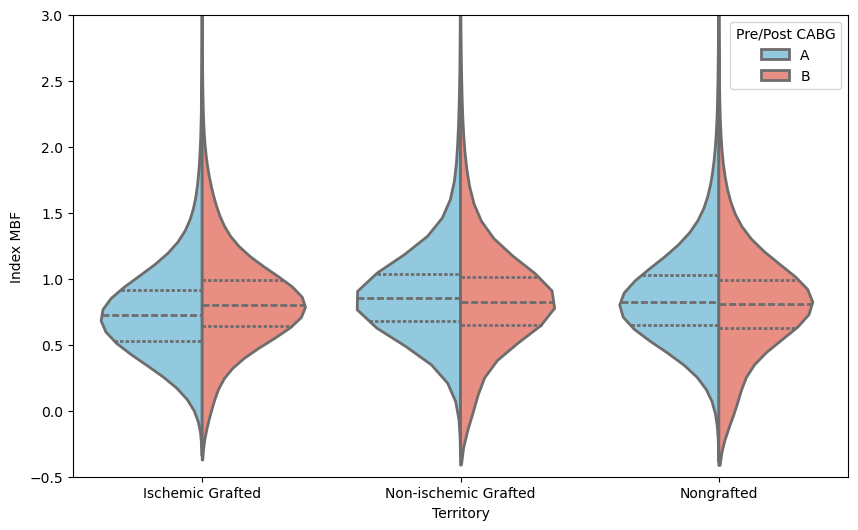

In [38]:
plt.figure(figsize=(10, 6))

sns.violinplot(x='Territory', y='MBF', hue='Type', data = df_long, split=True, inner = 'quartiles', bw_adjust = 10, scale_hue=False, linewidth= 2, palette={'A':'skyblue', 'B':'salmon'})

plt.ylabel("Index MBF")
#plt.xlabel("Group")
plt.legend(title="Pre/Post CABG")
plt.ylim([-0.5, 3])
plt.show()